# Schroedinger equation numerical solution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.integrate import simpson 

In [2]:
sec = 'bb' # use cc or bb for charmonium and bottomonium respectively
hbc = 0.1973269788
mc = 1.592 # charm mass in RS' scheme at nu_f=0.7gev
mb = 4.949 # bottom mass in RS' scheme at nu_f=0.7gev

sp_tab = np.loadtxt('V0tab_1.txt')      # Load tabulated potential in GeV units
pot = interp1d(sp_tab[:,0],sp_tab[:,1]) # potential function generated interpolating the data

def sctsl(vcc,vbb):  # this function selects values that are different for the two heavy quark sectors
    if sec == 'cc': aux = vcc
    elif sec == 'bb': aux = vbb
    return aux

0 1 -0.2911932000000004 1.2301754088629864 0.3122340579426679 1


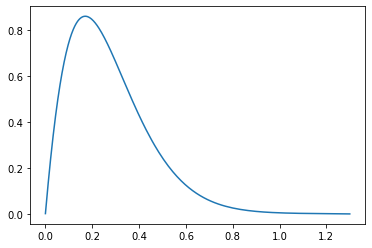

0 2 0.16837845999999973 0.6633984247849024 0.3392709122730942 1


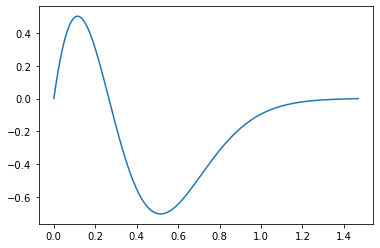

0 3 0.4915803829999997 0.5110343040754216 0.4199043586427763 3


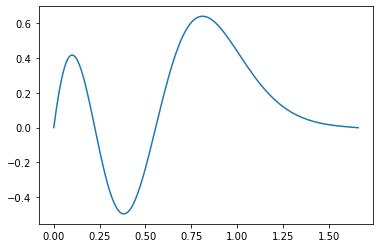

0 4 0.7670064021499996 0.4313944060496234 0.4992247070470917 4


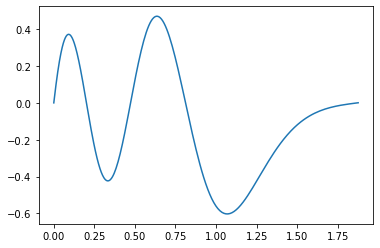

0 5 1.0148387222574988 0.3800737775846475 0.5742830220764386 5


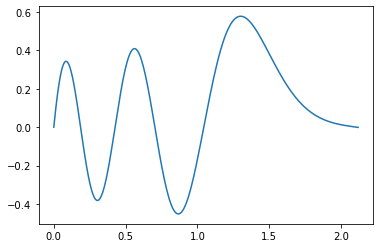

0 6 1.243802658370373 0.3433504069930129 0.6453303588621296 6


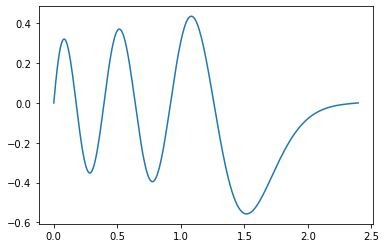

0 7 1.4586947912888912 0.31540889484767753 0.7131813747785047 6


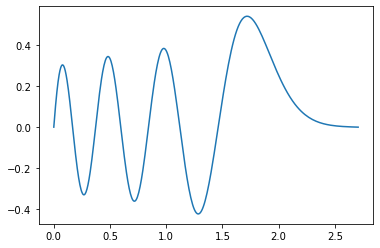

0 8 1.6624880408533358 0.2932081094151849 0.7782745296770881 7


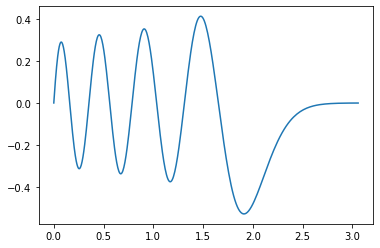

1 1 0.05887199999999992 0.5789576788918613 0.2807474632326453 1


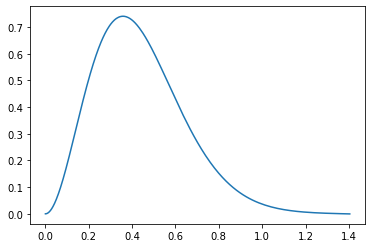

1 2 0.38947759999999987 0.4446100217621636 0.36961754684931564 2


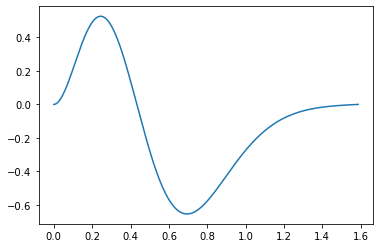

1 3 0.6709124799999996 0.3746400589846144 0.45374039391216997 3


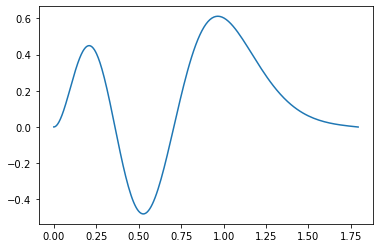

1 4 0.9235581039999996 0.3298208349279685 0.5322324699910167 4


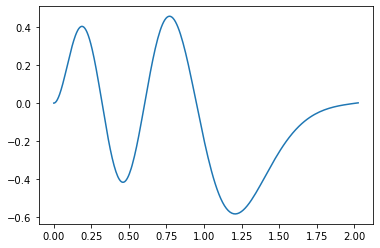

1 5 1.1564610091999987 0.2978811859113425 0.6058233082309787 5


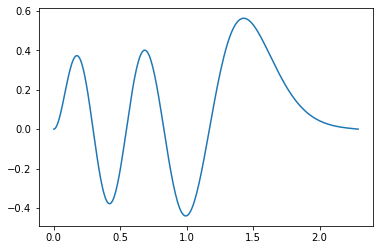

1 6 1.3746590596599988 0.2736646107386937 0.6756807769927954 6


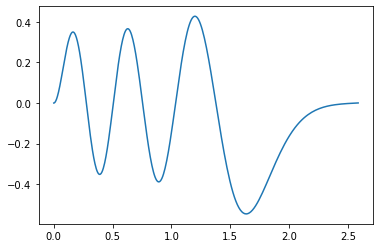

1 7 1.5812834126429987 0.25448030090426366 0.7424255939767146 6


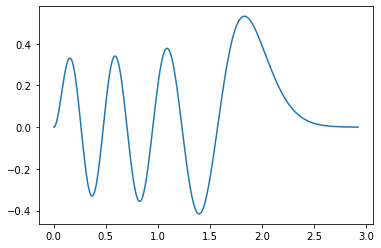

1 8 1.7784555832751472 0.2387874566233362 0.8064989143686923 7


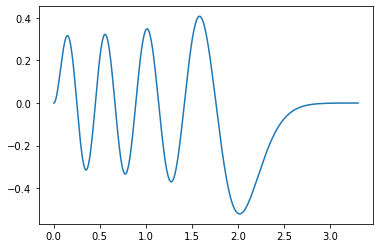

2 1 0.27447999999999995 0.410511955781469 0.31739109827708367 1


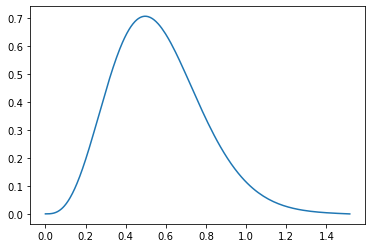

2 2 0.564716 0.34628451043140773 0.4078663073801164 2


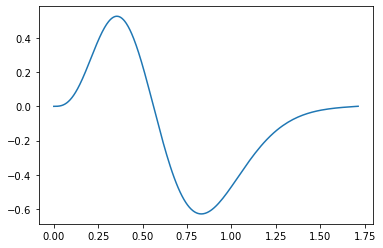

2 3 0.8237947999999998 0.3050794914718375 0.4905382549501078 3


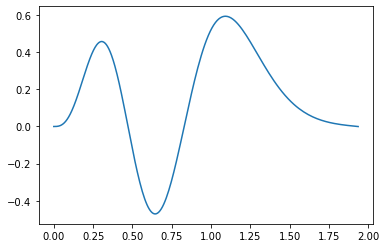

2 4 1.0617145399999992 0.27571409644913747 0.5672405280830805 3


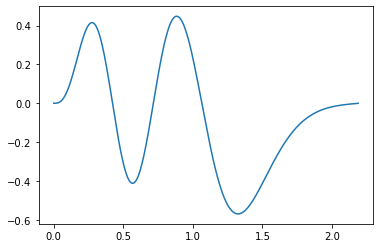

2 5 1.2839832669999987 0.25342273079839084 0.6394180696370056 5


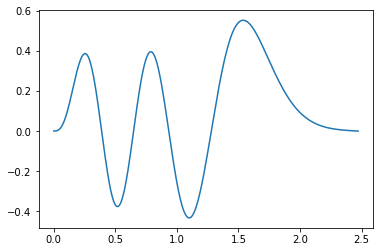

2 6 1.494014430349998 0.2357515947698404 0.7079820416735894 6


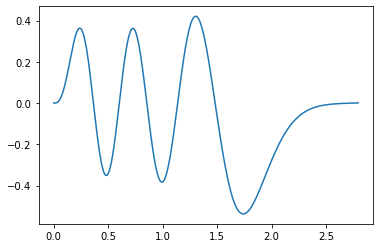

too much!
2 7 1.6941041618674972 0.22129157334160282 0.7735441161412322 6


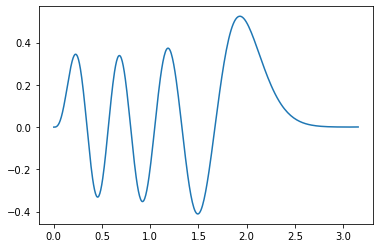

too much!
2 8 1.885889779960872 0.2091703087345077 0.8365478542694937 7


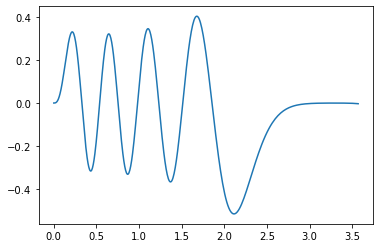

In [3]:
mq = sctsl(mc, mb) # picks heavy quark mass 

# Each step in the loop increses the energy tested by stp*10**(-sf)

stp = 1 # order 1 factor multipling the energy step
sf = 1  # scale factor controling the order of magnitude of the initial steps (now set to 0.1)
sd = 8  # significant digits in the final results of the energies (more or less...). More is needed for larger maxr
spec = []

for l in range(0,3): # We loop over angular momentum 0,1,2; to be adjusted as needed
    en = -1    # Starting energy for the scan
    for n in range(1,9):  # We loop over principal quarntum number n=1..8; to be adjusted as needed
        
        # Minimum value of the range of r for which we will solve the Schroedinger eq. Must be larger than r of the first data 
        # point of the potential.
            
        minr = 10**(-4+l/4)
        
        # Maximum value of the range of r. Ideally the larger the better, however larg values result in the need to find the
        # eigenenergies with unpractical accuracies. The most practial max r is just a few tens of a fm beyond where the wave 
        # function becomes almost zero, which I determine by trial an error and cheking the resulting wave functions. For 
        # increasing n and l we expect the extension of the wave function to increase. However, the scalings are also obtained  
        # by trial an error (maybe exact solutions of linear potentials could be used as a guide too?).
        
        maxr = sctsl(2.05*(1.1**(n-1))*(1.1**l)/hbc,1.3*(1.13**(n-1))*(1.08**l)/hbc)
        
        r_range =  [minr, maxr]
        
        # Boundary conditions of the r.w.f. and its derivative. These are obtained from the solution for the schroedinger
        # eq. in the short distance
        
        y_minr = [minr**(l+1),(l+1)*minr**l]
        
        # We rewrite the schroedinger eq. into a linear system y'=func(r,y)
        
        def func(r,y):
            return [y[1], (mq*(pot(r)-en)+l*(l+1)/r**2)*y[0]]   # y[0]= psi(r) (*reduced* w.f.) y[1]= psi(r)'
                 
        # we solve the diff. eq. for the initial value and find the sign of the divergence
        
        in_psi = solve_ivp(func,r_range,y_minr, rtol=10**(-sd-1), atol=10**(-sd-1)) 
        ref_sgn = np.sign(in_psi.y[0][-1]) 
        
        # Now we start the loop that scans the energy (from the initial value and incresing) until it finds an eigenenergy up to
        # some accuracy
        
        while True:
            en = en + stp*10**(-sf) # Adding energy step
            psi = solve_ivp(func,r_range,y_minr, rtol=10**(-sd-1), atol=10**(-sd-1), events = lambda r, y : y[0]) # Solve diff.eq. for the energy of the step
            ref = np.absolute(psi.y[0][-2])/np.nanmax(np.absolute(psi.y[0])) # value of the r.w.f. at the edge of the range over it max.value
            sgn = np.sign(psi.y[0][-2]) # sign of the r.w.f at the edge of the r range

            if ref < 1e-3: # We approximate the eigenenergy by the value of en when ref is this small
                break      # We exit the loop
            if sf == sd:   # We exit the loop if the number of significat digits of the energy becomes too large
                print('too much!') # if this prints the convergences conditions are too harsh
                break
            if sgn != ref_sgn: # If the sign of the large r divergence changes means we have crossed an eigenvalue
                en = en - stp*10**(-sf) # Undo the last energy step
                sf=sf+1 # We increase the scale factor so the next energy step is one order of magnitude smaller.
        
        nzeros= psi.t_events[0].size # should count the nodes, but its not working cos at large r r.w.f is very close to 0
        norm = np.sqrt(simpson(psi.y[0]**2,psi.t)) # we normalize the r.w.f
        npsi = psi.y[0]/norm
        oor = simpson(npsi**2/psi.t,psi.t) # <1/r> expected value
        kin = en - simpson(npsi**2*pot(psi.t),psi.t) # kinetic energy expected value
        np.savetxt(sec+'/wf_'+sec+'_'+str(l)+str(n)+'.txt', np.column_stack((psi.t, npsi)), fmt='% 6.5f', delimiter='  ') # save r.w.f
        spec.append([l, n, en, en + 2*mq, oor, kin]) # store spectrum data
        print(l, n, en, oor, kin, nzeros)
        plt.plot(psi.t*hbc,npsi)
        plt.show()
        
        en = en + np.absolute(en)*0.05 # Jump the energy past the eigenvalue so the next loop looks for a higher energy one
        sf = 1 # reset the scale factor for the next loop

aux = pd.DataFrame(spec, columns =  ['l','n','E0[GeV]','M[GeV] ','<1/r>  ','Ek[GeV]'])
aux.to_csv(sec+'/spec'+sec+'.txt', sep = '\t', float_format='% .4f', index=False)  # save spectrum data into a file